# Google Analytics Google Merchandise Kaggle Competition

Problem: The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

Goal: predict revenue per customer to drive operational changes and a better use of marketing budgets

In [1]:
#Utitlities
import random
import json
import datetime

#Data Manipulation
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

#Preprocessing
from sklearn.preprocessing import Imputer, MinMaxScaler

#testing and validation
from sklearn.cross_validation import train_test_split, cross_val_score, KFold

#Models
from sklearn.tree import DecisionTreeClassifier, export_graphviz

#Metrics
from sklearn.metrics import mean_squared_error

#ipython display
import warnings
warnings.filterwarnings('ignore')

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_file = './all/train.csv'

In [3]:
np.random.seed(42)
train_df = pd.read_csv(train_file, header=0, skiprows=lambda x: (x>0) & (np.random.random() > 0.3))

- **fullVisitorId** - A unique identifier for each user of the Google Merchandise Store.


- **channelGrouping** - The channel via which the user came to the Store.


- **date** - The date on which the user visited the Store.


- **device** - The specifications for the device used to access the Store.


- **geoNetwork** - This section contains information about the geography of the user.


- **sessionId** - A unique identifier for this visit to the store.


- **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".


- **totals** - This section contains aggregate values across the session.


- **trafficSource** - This section contains information about the Traffic Source from which the session originated.


- **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.


- **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.


- **visitStartTime** - The timestamp (expressed as POSIX time).

## Data Preprocessing

In [4]:
# This function is to extract date features
def date_process(df):
    df['date'] = df['date'].astype(str) # transforming the date column in string
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:]) # setting a new format to date column yyyy-mm-dd
    df["date"] = pd.to_datetime(df["date"]) # seting the column as pandas datetime

    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["year"] = df['date'].dt.year #extracting the year 
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month #extracting month
    
    return df #returning the df after the transformations


#unpack json columns
columns = ['totals','device','geoNetwork','trafficSource']
dfs = [train_df[['sessionId',col]].set_index('sessionId')[col].apply(lambda x: pd.Series(json.loads(x))) for col in columns]
df1 = dfs.pop(0)
unpacked = df1.join(dfs)
del dfs
del df1
unpacked.replace(['not available in demo dataset','(not set)','(not provided)'],np.nan, inplace=True)
unpacked['transactionRevenue'].fillna(0, inplace=True)
unpacked.transactionRevenue = unpacked.transactionRevenue.astype(np.float)
unpacked.transactionRevenue = unpacked.transactionRevenue.apply(lambda x: x/1000000)
unpacked.drop([col for col in unpacked.columns if ((unpacked[col].isnull().sum())==(unpacked.shape[0]))], axis=1, inplace=True)
unpacked.drop('adwordsClickInfo', axis=1, inplace=True)
train_df.drop(columns, axis=1, inplace=True)
train_df = pd.merge(train_df, unpacked, right_index=True, left_on='sessionId')
    
#drop cols that don't add value, have too many nulls, etc
drop_cols = ['campaign','campaignCode','keyword','adContent','city','region','metro','referralPath','networkDomain','operatingSystem','source','medium','isTrueDirect','visits','socialEngagementType']
train_df.drop(drop_cols, axis=1, inplace=True)
#convert date to datetime and extract month, day, year into new features
train_df = date_process(train_df)
#encode binary variables
train_df['bounces'] = 1*(train_df['bounces']=='1')
train_df['newVisits'] = 1 * (train_df['newVisits']=='1')
train_df['isMobile'] = 1*(train_df['isMobile'])
#impute most frequent observation
train_df.loc[train_df.subContinent.isnull(),'country'] = 'United States'
train_df.loc[train_df.subContinent.isnull(),'continent'] = 'Americas'
train_df.loc[train_df.subContinent.isnull(),'subContinent'] = 'North America'
train_df.loc[train_df['browser'].isnull(),'browser']='Chrome'
#convert data types
train_df['hits'] = pd.to_numeric(train_df['hits'])
train_df['pageviews'] = pd.to_numeric(train_df['pageviews'])
train_df.loc[train_df['pageviews'].isnull(),'pageviews'] = 3
train_df.sort_values(['date'], inplace=True)

## Target Distribution

Text(0.5,1,'Distribuition of Revenue Log')

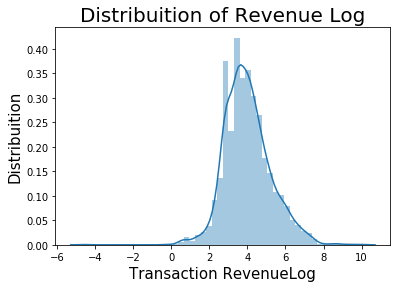

In [5]:
ax = sns.distplot(np.log(train_df[train_df['transactionRevenue']>0].groupby('fullVisitorId')['transactionRevenue'].sum()),bins=50)
ax.set_xlabel('Transaction RevenueLog', fontsize=15) #seting the xlabel and size of font
ax.set_ylabel('Distribuition', fontsize=15) #seting the ylabel and size of font
ax.set_title("Distribuition of Revenue Log", fontsize=20) #seting the title and size of font

In [6]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,hits,pageviews,bounces,newVisits,transactionRevenue,browser,isMobile,deviceCategory,continent,subContinent,country,weekday,year,day,month
161191,Direct,2016-08-01,906139263149526246,906139263149526246_1470069362,1470069362,1,1470069362,1,1.0,1,1,0.0,Safari,1,mobile,Americas,Northern America,United States,0,2016,1,8
161314,Organic Search,2016-08-01,9290558425075999936,9290558425075999936_1470055386,1470055386,1,1470055386,4,3.0,0,1,0.0,Opera,0,desktop,Asia,Southern Asia,Pakistan,0,2016,1,8
161315,Organic Search,2016-08-01,4033613882118163102,4033613882118163102_1470102227,1470102227,1,1470102227,4,3.0,0,1,0.0,Chrome,1,tablet,Asia,Southern Asia,Sri Lanka,0,2016,1,8
161316,Organic Search,2016-08-01,4356368670265924289,4356368670265924289_1470066890,1470066890,1,1470066890,4,3.0,0,1,0.0,Chrome,0,desktop,Asia,Southeast Asia,Indonesia,0,2016,1,8
161317,Organic Search,2016-08-01,5747223272231686932,5747223272231686932_1470117079,1470117079,1,1470117079,4,3.0,0,1,0.0,Chrome,1,mobile,Americas,Northern America,United States,0,2016,1,8


In [8]:
train_df.channelGrouping.unique()

array(['Direct', 'Organic Search', 'Referral', 'Social', 'Paid Search',
       'Affiliates', 'Display', '(Other)'], dtype=object)

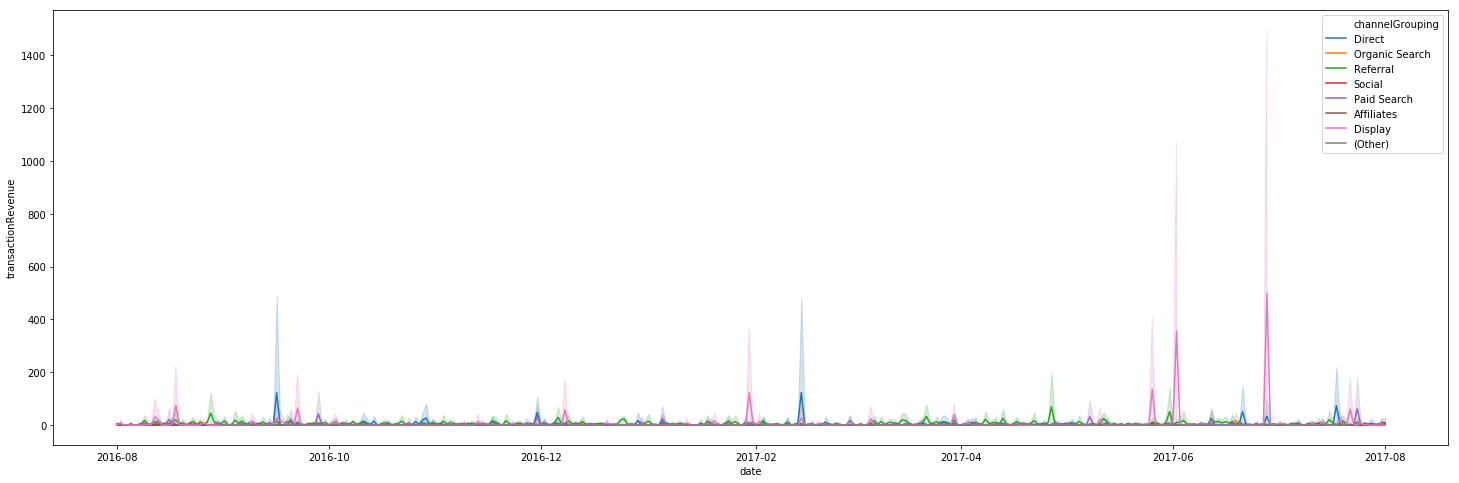

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,8))
sns.lineplot(x='date', y='transactionRevenue', hue='channelGrouping', data=train_df, ax=ax)

In [33]:
visitsByChannel = train_df[train_df['transactionRevenue']>0].groupby(['date','channelGrouping'])['fullVisitorId'].size()

In [34]:
visitsByChannel.name = 'visits'

In [36]:
visitsByChannel = visitsByChannel.reset_index()

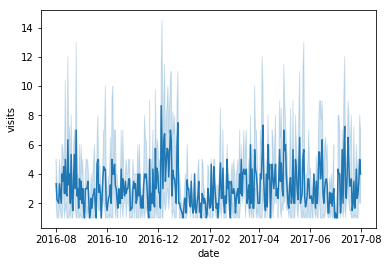

In [39]:
sns.lineplot(x='date', y='visits', data=visitsByChannel)